In [26]:
from brian2 import *
from DynapSE import DynapSE
from scipy import signal
import matplotlib.pyplot as plt
from data_loader import load_pickle

from ADM import ADM

In [27]:
# load PPG data
data = load_pickle(5)
PPG_signal = data['signal']['wrist']['BVP']

# load heart rate data
bpm = data['label'] 

In [28]:
def generate_spikes_manually():
    input_frequencies = [300, 400]
    indices = []
    times = []
    for i, freq in enumerate(input_frequencies):
        noise_mean = 1 / freq
        noise_std = 1 / freq / 8
        timesteps = int(freq * duration / second)
        indices = np.concatenate([indices, np.ones(timesteps) * i], axis=0)
        times = np.concatenate([
            times,
            np.arange(0, 4, 1 / freq)# + np.random.normal(noise_mean, noise_std, timesteps)
        ], axis=0)

    return SpikeGeneratorGroup(len(input_frequencies), indices, times * second)

In [29]:
def ADM_spikes(signal):
    
    # generate spikes
    up_spikes, down_spikes = ADM(
        PPG_signal,
        up_threshold=10,
        down_threshold=10,
        sampling_rate=64,
        refractory_period=0
    )
    
    return SpikeGeneratorGroup(1, np.zeros(len(up_spikes)), up_spikes * second)

In [30]:
device.reinit()
device.activate()
defaultclock.dt = 5000 * us
duration = 100 * second

network = Network()
chip = DynapSE(network)

# create ppg_spikes
ppg_segment_length = int(duration / second * 64)
spike_generator = ADM_spikes(PPG_signal[:ppg_segment_length])

# instantiate neurons, synapses
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 600

# set parameters of neurons, synapses
I_tau_syn_value = 0.5 * pA
ampa_conf = {
    "I_tau_syn_exc2": I_tau_syn_value,
    "I_g_syn_exc2": I_tau_syn_value
}
chip.set_param(ampa_conf, 'Core_1')

# create monitors
mon_synapse_state = StateMonitor(DPI_synapse, 'I_syn_exc2', record=True)
mon_neuron_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
mon_neuron_input  = SpikeMonitor(spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# add elements to network
network.add([spike_generator, DPI_neuron, DPI_synapse, 
             mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

# simulation
network.run(duration)

1 neurons are allocated from Core_1.


TemplateNotFound: common_group.pyx

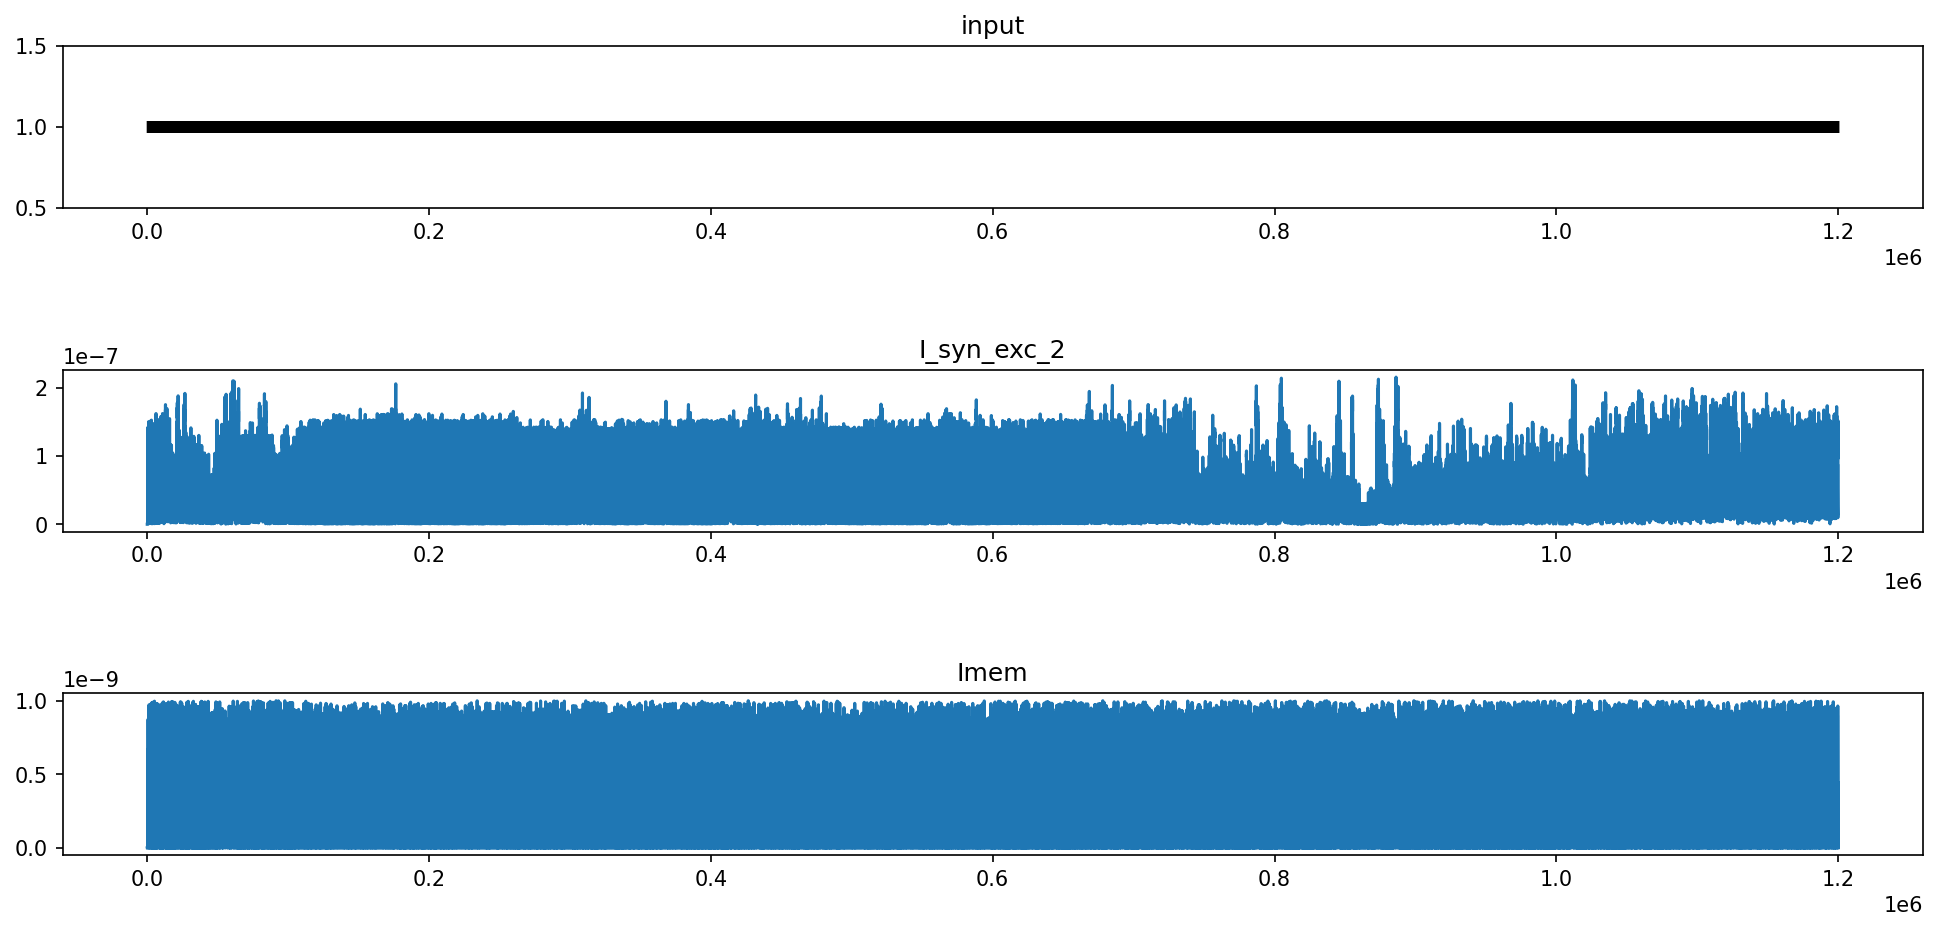

In [7]:
plt.figure(figsize=(16,10),dpi=150)
plt.subplots_adjust(hspace=1)

plt.subplot(411)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('input')

plt.subplot(412)
plt.plot(mon_synapse_state.t / ms, mon_synapse_state.I_syn_exc2[0])
plt.title('I_syn_exc_2')

plt.subplot(413)
plt.plot(mon_neuron_state.t / ms, mon_neuron_state.Imem[0])
plt.title('Imem')

plt.show()

In [8]:
mon_neuron_input.t.shape

(15913,)

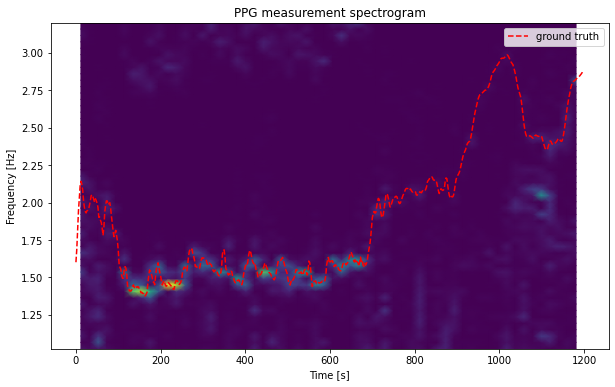

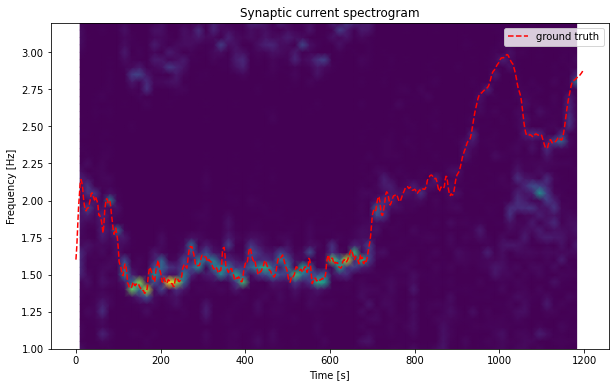

In [9]:
synaptic_current = mon_synapse_state.I_syn_exc2[0]
original_ppg = PPG_signal[:ppg_segment_length, 0]
#ts = mon_neuron_state.Imem[0]
#ts = ts - ts.mean()

bpm_hz = bpm / 60
bpm_segment_length = int(duration / second / 2)

fs_ppg = 64
fs_syn = 10e5 / defaultclock.dt * us
nperseg_ppg = 1500
nperseg_syn = 4000

f_ppg, t_ppg, Sxx_ppg = signal.spectrogram(original_ppg, fs_ppg, nperseg=nperseg_ppg)
f_syn, t_syn, Sxx_syn = signal.spectrogram(synaptic_current, fs_syn, nperseg=nperseg_syn)

fmin = 1 # Hz
fmax = 3.2 # Hz
freq_slice_ppg = np.where((f_ppg >= fmin) & (f_ppg <= fmax))
freq_slice_syn = np.where((f_syn >= fmin) & (f_syn <= fmax))

# keep only frequencies of interest
f_ppg = f_ppg[freq_slice_ppg]
f_syn   = f_syn[freq_slice_syn]
Sxx_ppg = Sxx_ppg[freq_slice_ppg,:][0]
Sxx_syn = Sxx_syn[freq_slice_syn,:][0]

# plot ppg spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='gouraud')
plt.title('PPG measurement spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.plot(np.arange(0, bpm_segment_length * 2, 2), bpm_hz[:bpm_segment_length], 'r--', label='ground truth')
plt.legend()
plt.show()

# plot synaptic current spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_syn, f_syn, Sxx_syn, shading='gouraud')
plt.title('Synaptic current spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.plot(np.arange(0, bpm_segment_length * 2, 2), bpm_hz[:bpm_segment_length], 'r--', label='ground truth')
plt.legend()
plt.show()

In [20]:
DPI_neuron = chip.get_neurons(2, 'Core_1')

2 neurons are allocated from Core_1.


In [23]:
DPI_neuron.I_tau_syn_exc2 = [1, 2] * pamp

In [24]:
DPI_neuron.I_tau_syn_exc2

<Core_1_subgroup_1.I_tau_syn_exc2: array([1., 2.]) * pamp>